# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [7]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [8]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [9]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [10]:
# Define model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

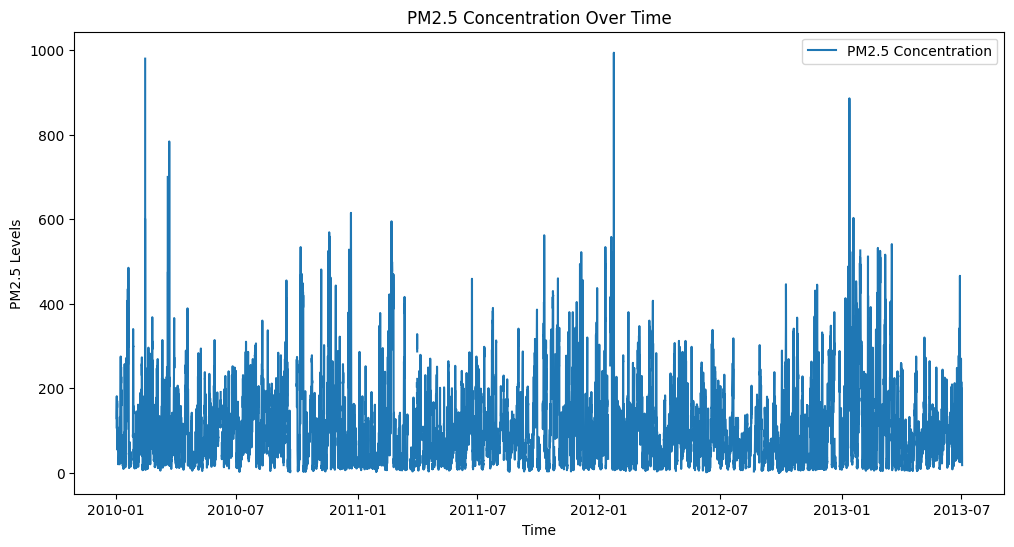

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
train = pd.read_csv('/content/train.csv')

# Convert datetime column to datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

# Set datetime as index
train.set_index('datetime', inplace=True)

# Plot PM2.5 concentrations over time
plt.figure(figsize=(12,6))
plt.plot(train['pm2.5'], label='PM2.5 Concentration')
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()


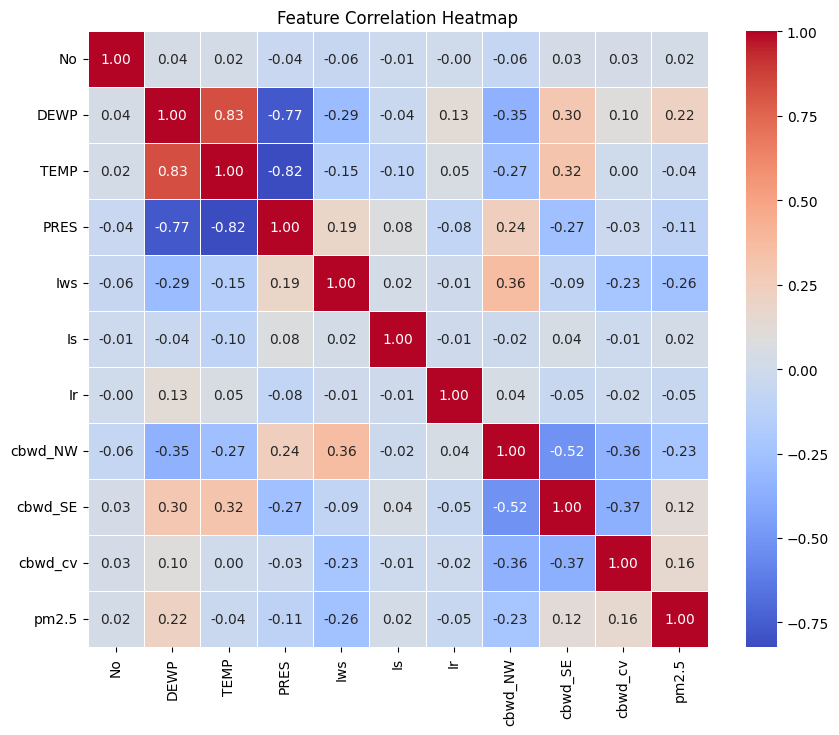

In [17]:
import seaborn as sns
import numpy as np

# Compute correlation matrix
corr_matrix = train.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


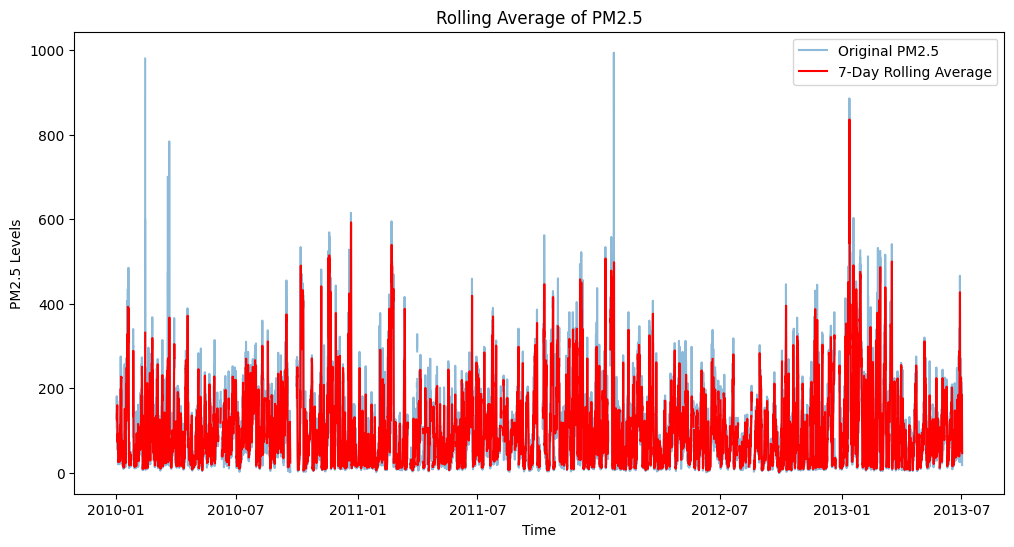

In [18]:
# Calculate 7-day rolling average
train['pm2.5_rolling_avg'] = train['pm2.5'].rolling(window=7).mean()

# Plot rolling average
plt.figure(figsize=(12,6))
plt.plot(train['pm2.5'], alpha=0.5, label='Original PM2.5')
plt.plot(train['pm2.5_rolling_avg'], color='red', label='7-Day Rolling Average')
plt.title('Rolling Average of PM2.5')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [11]:
# Define model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]
)

# Display the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 1, 64)               │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 110.6919 - loss: 13214.2314
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - lambda: 73.5839 - loss: 5733.5527
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - lambda: 72.2425 - loss: 5537.1118
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - lambda: 72.0374 - loss: 5497.9712
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 71.7442 - loss: 5424.8687
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - lambda: 71.8954 - loss: 5476.0620
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 70.5872 - loss: 5255.7578
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - lambda: 71.2816 - loss: 5409.7612
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - lambda: 70.6509 - loss: 5219.0674
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - lambda: 70.5074 - loss: 5266.7646


959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


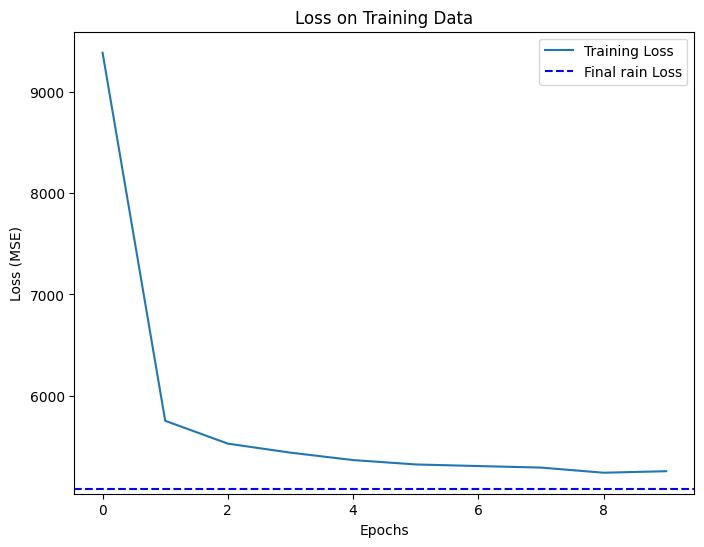

Final Training Loss (MSE): 5079.993566117271


In [13]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [15]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/subm_fixed3.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
